In [60]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
# from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CyclicLR, LambdaLR, ReduceLROnPlateau, MultiStepLR

from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, RandomResizedCrop, Normalize
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, inception_v3
# from torchvision.models.alexnet import AlexNet_Weights
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models.inception import Inception_V3_Weights
# from torchvision.models.vgg import VGG16_Weights

from torch_lr_finder import LRFinder

from tqdm.auto import tqdm
from datetime import datetime as dt
import os
import random
from copy import deepcopy
from pathlib import Path
import shutil

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# Setting the data for testing

np.random.seed(42)
X = np.random.randn(1000, 5)

a = np.array([0.2, 0.1, 0.4, -0.7, 0.03]).reshape(-1, 1)
b = -0.9
y = b + X @ a

print(X.shape, y.shape)

(1000, 5) (1000, 1)


# Data configuration

In [4]:
%%writefile data_config/data_prep.py

np.random.seed(42)
X = np.random.randn(1000, 5)

a = np.array([0.2, 0.1, 0.4, -0.7, 0.03]).reshape(-1, 1)
b = -0.9
y = b + X @ a

X_tensor = torch.as_tensor(X).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(X.shape[0] * 0.8)
valid_size = X.shape[0] - train_size

train_data, valid_data = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

valid_loader = DataLoader(
    dataset=valid_data,
    batch_size=32
)

Overwriting data_config/data_prep.py


# Model configuration

In [5]:
%load_ext tensorboard
%tensorboard --logdir summary

Reusing TensorBoard on port 6006 (pid 17044), started 1 day, 22:47:47 ago. (Use '!kill 17044' to kill it.)

In [6]:
%%writefile model_config/model_setting.py

def create_train_step_fn(model, loss_fn, optimizer):
    def output_train_step_loss(X, y):
        model.train()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return output_train_step_loss

def create_valid_step_fn(model, loss_fn):
    def output_valid_step_loss(X, y):
        model.eval()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        return loss.item()
    return output_valid_step_loss

def get_mini_batch_loss(device, data_loader, step_fn):
    mini_batch_losses = []
    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        batch_loss = step_fn(X_batch, y_batch)
        mini_batch_losses.append(batch_loss)
    
    return np.mean(mini_batch_losses)

lr = 0.01

torch.manual_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(nn.Linear(5, 1)).to(device)

loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=lr)

train_step_fn = create_train_step_fn(model, loss_fn, optimizer)
valid_step_fn = create_valid_step_fn(model, loss_fn)

tensorboard_writer = SummaryWriter('summary/simple_linear_reg')

Overwriting model_config/model_setting.py


# Model training

In [7]:
%%writefile model/train.py

n_epochs = 100

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = get_mini_batch_loss(device=device, data_loader=train_loader, step_fn=train_step_fn)
    train_losses.append(train_loss)

    with torch.no_grad():
        valid_loss = get_mini_batch_loss(device=device, data_loader=valid_loader, step_fn=valid_step_fn)
        valid_losses.append(valid_loss)

    tensorboard_writer.add_scalars(
        main_tag = 'losses',
        tag_scalar_dict = {
            'train': train_loss,
            'validation': valid_loss
        },
        global_step = epoch
    )

tensorboard_writer.close()

Overwriting model/train.py


In [8]:
%run -i data_config/data_prep.py
%run -i model_config/model_setting.py
%run -i model/train.py

In [9]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2000,  0.1000,  0.4000, -0.7000,  0.0300]], device='cuda:0')),
             ('0.bias', tensor([-0.9000], device='cuda:0'))])

# DLAssistant class creation

In [10]:
%%writefile data_config/data_prep_v2.py

class CustomDataset(Dataset):

    def __init__(self, X, y, X_transform=None):
        self.X = X
        self.y = y 
        self.X_transform = X_transform

    def __getitem__(self, index):
        X = self.X[index]

        if self.X_transform is not None:
            X = self.X_transform(X)

        return X, self.y[index]

    def __len__(self):
        return len(self.X)

def index_splitter(data_size, splits, seed=13):
    idxs = torch.arange(data_size)
    splits_tensor = torch.as_tensor(splits)
    multiplier = data_size / splits_tensor.sum()
    splits_tensor = (multiplier * splits_tensor).long()
    diff = data_size - splits_tensor.sum()
    splits_tensor[0] += diff
    torch.manual_seed(seed)
    return random_split(idxs, splits_tensor)

def create_balanced_sampler(y):

    classes, counts = y.unique(return_counts=True)
    weights = 1 / counts.float()
    sample_weights = weights[y.squeeze().long()]

    generator = torch.Generator()

    weighted_sampler = WeightedRandomSampler(
        weights=sample_weights,
        number_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )

    return weighted_sampler

Overwriting data_config/data_prep_v2.py


In [68]:
%%writefile assistent/model.py
class DLAssistant(object):
    
    def __init__(self, model, loss_fn, optimizer):

        self.model = model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.train_loader = None
        self.valid_loader = None
        self.tensorboard_writer = None

        self.train_losses = []
        self.valid_losses = []
        self.total_epochs = 0

        self.train_step_fn = self._create_train_step_fn()
        self.valid_step_fn = self._create_valid_step_fn()

        self.layer_output_dict = {}
        self.hook_handlers_dict = {}

        self.scheduler = None
        self.is_batch_lr_scheduler = False
        self.learning_rates = []

    def to(self, device):

        try:
            self.model = self.model.to(device)
            self.device = device
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.model = self.model.to(self.device)
            print(f"{device} device is not accessable!!!\n{self.device} is used!!!")

    def set_loaders(self, train_loader, valid_loader=None):
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def set_tensorboard(self, name, log_dir='summary'):
        
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)

        name_suffix = dt.now().strftime('%Y%m%d_%H%M%S')
        full_name = f"{log_dir}/{name}_{name_suffix}"
        self.tensorboard_writer = SummaryWriter(full_name)

    def _create_train_step_fn(self):

        def get_train_loss(X, y):
            self.model.train()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        
        return get_train_loss
    
    def _create_valid_step_fn(self):
        
        def get_valid_loss(X, y):
            self.model.eval()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            return loss.item()
        
        return get_valid_loss
    
    def _get_mini_batch_loss(self, validation=False):

        if validation:
            data_loader = self.valid_loader
            step_fn = self.valid_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        n_batches = len(data_loader)

        mini_batch_losses = []

        for i, (X_batch, y_batch) in enumerate(data_loader):
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(X_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

            if not validation:
                self._step_mini_batch_schedulers(i / n_batches)

        return np.mean(mini_batch_losses)
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass
    
    def train(self, n_epochs, seed=42):

        self.total_epochs += 1

        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):

            train_loss = self._get_mini_batch_loss()
            self.train_losses.append(train_loss)

            with torch.no_grad():
                valid_loss = self._get_mini_batch_loss(validation=True)
                self.valid_losses.append(valid_loss)

            self._step_epoch_schedulers(valid_loss)

            if self.tensorboard_writer is not None:
                scalar_dict = {'train': train_loss}
                if self.valid_loader is not None:
                    scalar_dict.update({'validation': valid_loss})
                self.tensorboard_writer.add_scalars(
                    main_tag = 'losses',
                    tag_scalar_dict = scalar_dict,
                    global_step = epoch
                )

        if self.tensorboard_writer is not None:
            self.tensorboard_writer.flush()

    def show_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.train_losses, label='train', c='blue')
        if self.valid_loader is not None:
            plt.plot(self.valid_losses, label='valid', c='orange')
        plt.yscale('log')
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        return fig
    
    def save_results(self, filepath):
        checkpoint_dict = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'total_epochs': self.total_epochs,
            'train_losses': self.train_losses,
            'valid_losses': self.valid_losses
        }
        torch.save(checkpoint_dict, filepath)

    def load_states(self, filepath):
        checkpoint_dict = torch.load(filepath)
        self.model.load_state_dict(checkpoint_dict['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
        self.total_epochs = checkpoint_dict['total_epochs']
        self.train_losses = checkpoint_dict['train_losses']
        self.valid_losses = checkpoint_dict['valid_losses']

        self.model.train()

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.as_tensor(X).float()
        X_tensor = X_tensor.to(self.device)
        pred_y = self.model(X_tensor).detach().cpu().numpy()
        self.model.train()
        return pred_y

    def count_parameters(self):
        parameter_number_list = [p.numel() for p in self.model.parameters() if p.requires_grad]
        return sum(parameter_number_list)

    def attach_hook(self, layers_to_hook_list, hook_fn=None):

        modules_list = list(self.model.named_modules())[1:]
        layer_names_dict = {elem[1]: elem[0] for elem in modules_list}

        self.layer_output_dict = {}

        if hook_fn is None:

            def hook_fn(layer, inputs, outputs):
                layer_name = layer_names_dict[layer]
                output_values = outputs.detach().cpu().numpy()
                if self.layer_output_dict[layer_name] is None:
                    self.layer_output_dict[layer_name] = output_values
                else:
                    self.layer_output_dict[layer_name] = np.concatenate(
                        [self.layer_output_dict[layer_name], output_values]
                    )

        for layer_name, layer in modules_list:
            if layer_name in layers_to_hook_list:
                self.layer_output_dict[layer_name] = None
                self.hook_handlers_dict[layer_name] = layer.register_forward_hook(hook_fn)

    def remove_hook(self):
        for handle in self.hook_handlers_dict.values():
            handle.remove()
        self.hook_handlers_dict = {}

    def show_metric(self, X, y, metric, is_classification=False, threshold=0.5):

        self.model.eval()
        X = torch.as_tensor(X).float()
        y_hat = self.model(X.to(self.device))
        self.model.train()

        if is_classification:
            
            if y_hat.size()[1] > 1:
                _, predicted_class = torch.max(y_hat, 1)
                predicted_class = predicted_class.detach().cpu().numpy()
            else:
                predicted_class = (torch.sigmoid(y_hat) > threshold).long()
                predicted_class = predicted_class.detach().cpu().numpy()

            return metric(y, predicted_class)

        else:

            return metric(y, y_hat.detach().cpu().numpy())
    
    @staticmethod
    def apply_fn_over_loader(loader, func, reduce='sum'):

        results = [func(X, y) for X, y in loader]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.mean(axis=0)

        return results

    @staticmethod
    def get_stats_per_channel(images, labels):
        n_samples, n_channels, height, width = images.size()
        flattened_images = images.reshape(n_samples, n_channels, -1)
        means = flattened_images.mean(axis=2)
        stds = flattened_images.std(axis=2)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        n_samples = torch.tensor([n_samples]*n_channels).float()
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def create_normalizer(loader):
        total_samples, total_means, total_stds = DLAssistant.apply_fn_over_loader(
            loader, DLAssistant.get_stats_per_channel
        )
        norm_mean = total_means / total_samples
        norm_stds = total_stds / total_samples
        return Normalize(norm_mean, norm_stds)

    @staticmethod
    def create_lr_fn(start_lr, end_lr, n_iter, lr_mode='exp'):
        if lr_mode == 'linear':
            lr_factor = (end_lr/start_lr - 1) / n_iter
            def lr_fn(iteration):
                return 1 + lr_factor * iteration
        if lr_mode == 'exp':
            lr_factor = np.log(end_lr/start_lr) / n_iter
            def lr_fn(iteration):
                return np.exp(lr_factor) ** iteration
        return lr_fn

    def lr_range_test(self, data_loader, end_lr, n_iter=100, lr_mode='exp', ewma_param=0.5):

        initial_state_dict = {
            'model': deepcopy(self.model.state_dict()),
            'optimizer': deepcopy(self.optimizer.state_dict())
        }

        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']
        lr_fn = DLAssistant.create_lr_fn(start_lr, end_lr, n_iter, lr_mode)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        tracking_dict = {'loss': [], 'lr': []}

        current_iteration = 0

        for X_batch, y_batch in data_loader:

            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            y_hat = self.model(X_batch)
            loss = self.loss_fn(y_hat, y_batch)

            tracking_dict['lr'].append(scheduler.get_last_lr()[0])

            if len(tracking_dict['loss']) == 0:
                tracking_dict['loss'].append(loss.item())
            else:
                tracking_dict['loss'].append((1-ewma_param)*tracking_dict['loss'][-1] + ewma_param*loss.item())

            loss.backward()
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

            current_iteration += 1

            if current_iteration == n_iter:
                break

        self.model.load_state_dict(initial_state_dict['model'])
        self.optimizer.load_state_dict(initial_state_dict['optimizer'])
            
        fig = plt.figure(figsize=(10, 6))
        plt.plot(tracking_dict['lr'], tracking_dict['loss'])
        if lr_mode == 'exp':
            plt.xscale('log')
        plt.xlabel('learning rate')
        plt.ylabel('loss')

        return tracking_dict, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_lr_scheduler(self, scheduler):
        if scheduler.optimizer == self.optimizer:
            self.scheduler = scheduler
            if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or\
                isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or\
                isinstance(scheduler, optim.lr_scheduler.Cosine)):
                self.is_batch_lr_scheduler = True
            else:
                self.is_batch_lr_scheduler = False

    def _step_epoch_schedulers(self, valid_loss):
        if self.scheduler is not None:
            if not self.is_batch_lr_sheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda x: x['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

    def _step_mini_batch_schedulers(self, frac_epoch):
        if self.scheduler is not None:
            if self.is_batch_lr_sheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
                    self.scheduler.step(self.total_epochs + frac_epoch)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda x: x['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

Overwriting assistent/model.py


In [24]:
%run -i data_config/data_prep.py
%run -i model_config/model_setting.py
%run -i assistent/model.py

dl_assistent = DLAssistant(model, loss_fn, optimizer)
dl_assistent.set_loaders(train_loader, valid_loader)
dl_assistent.set_tensorboard(name='class_linear_reg')
dl_assistent.train(n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

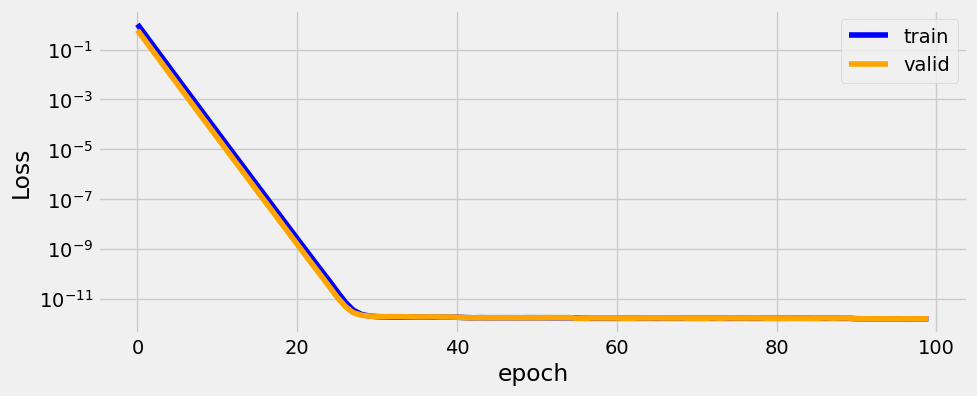

In [24]:
loss_fig = dl_assistent.show_losses();

In [25]:
dl_assistent.model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2000,  0.1000,  0.4000, -0.7000,  0.0300]], device='cuda:0')),
             ('0.bias', tensor([-0.9000], device='cuda:0'))])

In [54]:
dl_assistent.save_results('checkpoint.pth')

In [55]:
dl_assistent.load_states('checkpoint.pth')

In [25]:
X_test = np.random.randn(5, 5)
dl_assistent.attach_hook(['0'])
model_pred = dl_assistent.predict(X_test)
dl_assistent.remove_hook()
model_pred

array([[-1.6285517 ],
       [-0.1370228 ],
       [ 0.34507674],
       [-0.3947935 ],
       [ 0.37855583]], dtype=float32)

In [20]:
dl_assistent.layer_output_dict

{'0': array([[-1.6285517 ],
        [-0.1370228 ],
        [ 0.34507674],
        [-0.3947935 ],
        [ 0.37855583]], dtype=float32)}

In [26]:
y_test = np.random.randn(5, 1)
dl_assistent.show_metric(X_test, y_test, metric=mean_squared_error)

0.909290407253015

In [26]:
dl_assistent.count_parameters()

6

# Classification problem

In [22]:
%%writefile data_config/data_prep_v3.py

TRAIN_PATH = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\PytorchDLAssistant/\data/\train")
VALID_PATH = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\PytorchDLAssistant/\data/\valid")

# if not os.path.exists(VALID_PATH):
#     os.mkdir(VALID_PATH)

# cat_list = os.listdir(TRAIN_PATH)

# for cat in tqdm(cat_list):

#     if not os.path.exists(os.path.join(VALID_PATH, cat)):
#         os.mkdir(os.path.join(VALID_PATH, cat))

#     files_list = os.listdir(os.path.join(TRAIN_PATH, cat))

#     total_files = len(files_list)
#     valid_files = int(total_files*0.2)
#     valid_idxs_list = list(np.random.choice(np.arange(total_files), valid_files, replace=False))

#     for i in valid_idxs_list:
#         shutil.move(
#             os.path.join(TRAIN_PATH, cat, files_list[i]),
#             os.path.join(VALID_PATH, cat, files_list[i])
#         )

temp_data_transform = Compose([Resize((28, 28)), ToTensor()])
temp_dataset = ImageFolder(root=TRAIN_PATH, transform=temp_data_transform)
temp_loader = DataLoader(dataset=temp_dataset, batch_size=16)

normalizer = DLAssistant.create_normalizer(temp_loader)

data_transform = Compose([Resize((28, 28)), ToTensor(), normalizer])

train_dataset = ImageFolder(root=TRAIN_PATH, transform=data_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

valid_dataset = ImageFolder(root=VALID_PATH, transform=data_transform)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=16)

Writing data_config/data_prep_v3.py


In [6]:
%%writefile model_config/model_setting_v2.py

lr = 0.01

model = nn.Sequential()
model.add_module('cnn1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1)) # 16@26X26
model.add_module('activation1', nn.ReLU())
model.add_module('pool1', nn.AvgPool2d(kernel_size=2)) # 16@13X13
model.add_module('cnn2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)) # 32@11X11
model.add_module('activation2', nn.ReLU())
model.add_module('pool2', nn.AvgPool2d(kernel_size=2)) # 32@5X5
# model.add_module('cnn3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)) # 64@3X3
# model.add_module('activation3', nn.ReLU())
# model.add_module('pool3', nn.AvgPool2d(kernel_size=2)) # 64@1X1
model.add_module('flatten', nn.Flatten())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('fc', nn.Linear(32*5*5, 42))

loss_fn = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=lr)

Writing model_config/model_setting_v2.py


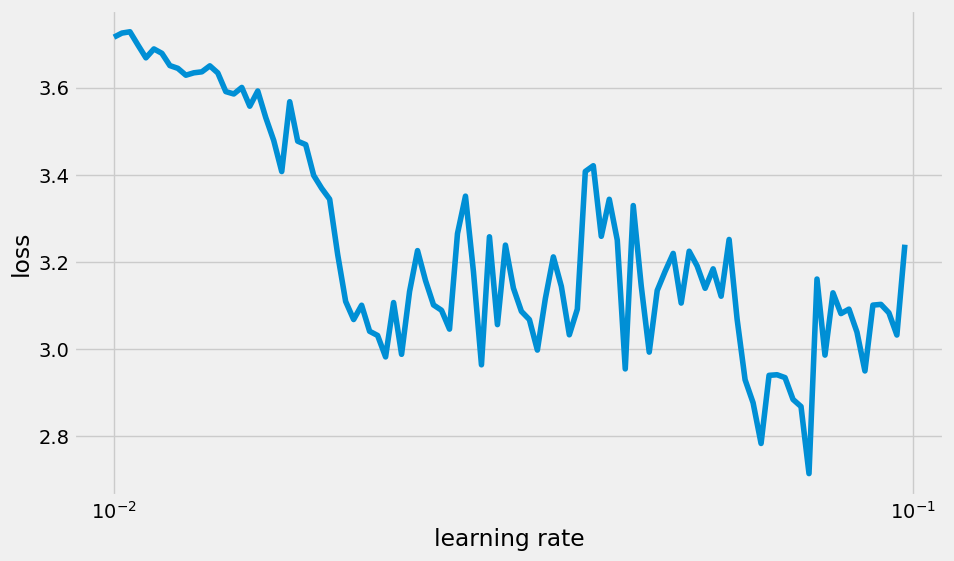

In [37]:
%run -i assistent/model.py
%run -i data_config/data_prep_v3.py
%run -i model_config/model_setting_v2.py

simple_clf_model = DLAssistant(model, loss_fn, optimizer)
simple_clf_model.lr_range_test(data_loader=train_loader, end_lr=0.03, n_iter=100, lr_mode='exp', ewma_param=0.5);

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.28E-02


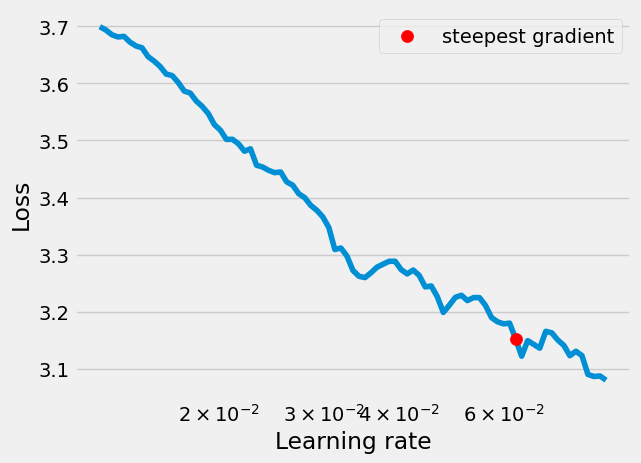

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(train_loader=train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(log_lr=True)
lr_finder.reset()

In [44]:
%run -i assistent/model.py
%run -i data_config/data_prep_v3.py
%run -i model_config/model_setting_v2.py

simple_clf_model = DLAssistant(model, loss_fn, optimizer)
new_optimizer = optim.SGD(model.parameters(), lr=6.28E-02)
simple_clf_model.set_optimizer(new_optimizer)
simple_clf_model.set_loaders(train_loader, valid_loader)
simple_clf_model.set_tensorboard('simple_clf')
simple_clf_model.train(n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

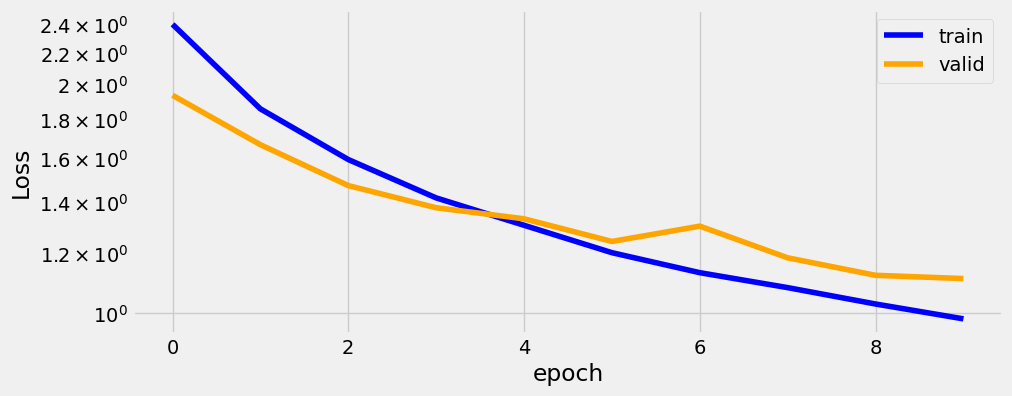

In [45]:
simple_clf_model.show_losses();

In [56]:
%run -i assistent/model.py
%run -i data_config/data_prep_v3.py
%run -i model_config/model_setting_v2.py

scheduler1 = StepLR(optimizer, step_size=4, gamma=0.5)

n_cycle_epochs = 5
step_size_up = int(len(train_loader) * n_cycle_epochs / 2)
scheduler2 = CyclicLR(optimizer, base_lr=1e-4, max_lr=6.28E-02, step_size_up=step_size_up, mode='triangular')
scheduler3 = CyclicLR(optimizer, base_lr=1e-4, max_lr=6.28E-02, step_size_up=step_size_up, mode='triangular2')
scheduler4 = CyclicLR(optimizer, base_lr=1e-4, max_lr=6.28E-02, step_size_up=step_size_up, mode='exp_range', gamma=np.sqrt(.5))

simple_clf_model = DLAssistant(model, loss_fn, optimizer)
new_optimizer = optim.SGD(model.parameters(), lr=6.28E-02)
simple_clf_model.set_optimizer(new_optimizer)
simple_clf_model.set_lr_scheduler(scheduler4)
simple_clf_model.set_loaders(train_loader, valid_loader)
simple_clf_model.set_tensorboard('simple_clf')
simple_clf_model.train(n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

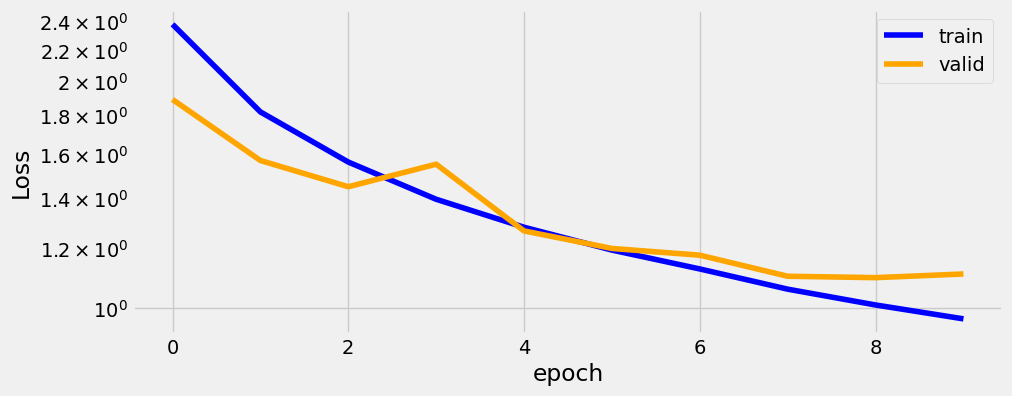

In [57]:
simple_clf_model.show_losses();

In [ ]:
optimizer = optim.SGD(
  model.parameters(), lr=0.1, momentum=0.9, nesterov=False
)

normalizer = Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225]
)

StepByStep.loader_apply(val_loader, sbs_alex.correct)

In [61]:
X_valid, y_valid = next(iter(valid_loader))
simple_clf_model.show_metric(X_valid, y_valid, metric=accuracy_score, is_classification=True)

In [72]:
%%writefile data_config/data_prep_v4.py

resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)

def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

freeze_model(resnet18_model)

resnet18_model.fc = nn.Identity()

# resnet18_model.fc = nn.Linear(2048, 42)
# resnet18_model

def extract_model_features(model, data_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    
    labels = None
    features = None

    for i, (X, y) in enumerate(data_loader):
        model.eval()
        output = model(X.to(device))
        if i == 0:
            labels = y.cpu()
            features = output.detach().cpu()
        else:
            labels = torch.cat([labels, y.cpu()])
            features = torch.cat([features, output.detach().cpu()])

    dataset = TensorDataset(features, labels)

    return dataset

TRAIN_PATH = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\PytorchDLAssistant/\data/\train")
VALID_PATH = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\PytorchDLAssistant/\data/\valid")

normalizer = Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225]
)

data_transform = Compose([Resize((28, 28)), ToTensor(), normalizer])

train_dataset = ImageFolder(root=TRAIN_PATH, transform=data_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

valid_dataset = ImageFolder(root=VALID_PATH, transform=data_transform)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=16)

train_feat_dataset = extract_model_features(resnet18_model, train_loader)
train_loader = DataLoader(dataset=train_feat_dataset, batch_size=16, shuffle=True)

valid_feat_dataset = extract_model_features(resnet18_model, valid_loader)
valid_loader = DataLoader(dataset=valid_feat_dataset, batch_size=16)

Overwriting data_config/data_prep_v4.py


In [74]:
%run -i data_config/data_prep_v4.py
%run -i assistent/model.py

model = nn.Sequential(nn.Linear(512, 42))
optimizer = optim.SGD(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

simple_clf_model = DLAssistant(model, loss_fn, optimizer)
simple_clf_model.set_loaders(train_loader, valid_loader)
simple_clf_model.set_tensorboard('simple_clf')
simple_clf_model.train(n_epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
X_valid, y_valid = next(iter(valid_loader))
simple_clf_model.show_metric(X_valid, y_valid, metric=accuracy_score, is_classification=True)

0.125

In [75]:
def inception_loss(outputs, labels):

    try:
        main, aux = outputs
    except ValueError:
        main = outputs
        aux = None
        aux_loss = 0

    multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
    main_loss = multi_loss_fn(main, labels)
    
    if aux is not None:
        aux_loss = multi_loss_fn(aux, labels)

    total_loss = main_loss + 0.4 * aux_loss

    return total_loss